In [5]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import scipy.io
import scipy
import random


class DataLoader:
    '''
    For load data and change shape to (x,y). x is the traing images and y is the label of the x.
    '''

    def __init__(self, file):

        self.data = scipy.io.loadmat(file, squeeze_me=True, struct_as_record=False)['mnist']
        self.train_images = self.data.train_images
        self.test_images = self.data.test_images
        self.train_labels = self.data.train_labels
        self.test_labels = self.data.test_labels

        # transform the raw data to binary data
        self.train_images = self.transform_images(self.train_images)
        self.test_images = self.transform_images(self.test_images)

        # reshape the training images to [784,1]
        self.train_images = [np.reshape(x, (784, 1)) for x in self.train_images]
        self.test_images = [np.reshape(x, (784, 1)) for x in self.test_images]

        labels = np.asarray(self.train_labels)
        selector = (labels == 3) | (labels == 7)
        self.train_labels = self.train_labels[selector]
        self.train_images = np.array(self.train_images)
        self.train_images = self.train_images[selector]
        ls= []
        for i in self.train_labels:
            if i == 3:
                ls.append([[1.],[0.]])
            else:
                ls.append([[0.],[1.]])
        self.train_labels = ls
        
        self.training_data = tuple(zip(self.train_images, self.train_labels))
        
#       test part
        labels = np.asarray(self.test_labels)
        selector = (labels == 3) | (labels == 7)
        self.test_labels = self.test_labels[selector]
        self.test_images = np.array(self.test_images)
        self.test_images = self.test_images[selector]
        ls= []
        for i in self.test_labels:
            if i == 3:
                ls.append([[1.],[0.]])
            else:
                ls.append([[0.],[1.]])
        self.test_labels = ls
        
        self.test_data = tuple(zip(self.test_images, self.test_labels))
        
        
    # function to reshape
    def transform_images(self, data):

        reshaped = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
        swapped_axes = np.swapaxes(reshaped, 0, 1)
        return swapped_axes * (1.0/256)
#         return (swapped_axes > 122) * 2.0 - 1

In [6]:
data = DataLoader('mnistALL.mat')

In [7]:
print data.test_data[101]

(array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 

In [8]:
class Network(object):

    def __init__(self, sizes):
        '''
        sizes is the structure of the whole network shown by [first layer, second layer, ... , last year] as a list
        different waies to initialize the weights and biases
        '''
        self.num_layers = len(sizes)
        self.sizes = sizes
#       the initialization of the weights and biases
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    # the feedward calculation of the network, which will return the result to the last layer
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    # stochastic gradient descent process, with training_data shaped like (x,y), x is the traing data,
#     and y is the target value. lr is the learning rate and mini_batch_size is mini batch size. test_data
#  is the part for validation
    def StochasticGradientDescent(self, training_data, epochs, mini_batch_size, lr,
            test_data=None):
        error = []
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
# shuffle command for shuffle the data set
            random.shuffle(list(training_data))
# here is the mini batches to train every time after shuffle the whole training set
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
# here is to test the validation percentage of the model
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr)
            if test_data:
                error.append(self.evaluate(test_data)/(len(test_data) * 1.0))
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
                
            else:
                print "complete"
        return error
# this function is to update the weights and biases after mini batches
    def update_mini_batch(self, mini_batch, lr):
# initialization the nabla
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
# here got updated by backpropagate
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
# did the update
        self.weights = [w-(lr/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(lr/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
# here is the specific backpropagate function
    def backprop(self, x, y):

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x] 
        zs = [] 
        # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
#         here the activation function is sigmoid
            activation = sigmoid(z)
            activations.append(activation)
        # this is the delta back pass to update
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_derive(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_derive(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
#         got the final nablas for weights and biases
        return (nabla_b, nabla_w)
# here evaluate the whole correctness of the training samples
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)
#  sigmoid function
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

# derivative of sigmoid function
def sigmoid_derive(z):
    return sigmoid(z)*(1-sigmoid(z))

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
formatter = FuncFormatter(to_percent)

In [18]:
training_data = data.training_data
validation_data = data.test_data


print len(data.training_data[0][0])
net = Network([784,10,5,2])
net.StochasticGradientDescent(training_data, 20, 10, 0.1, test_data=validation_data)


784
Epoch 0: 1519 / 2038
Epoch 1: 1865 / 2038
Epoch 2: 1919 / 2038
Epoch 3: 1942 / 2038
Epoch 4: 1951 / 2038
Epoch 5: 1953 / 2038
Epoch 6: 1957 / 2038
Epoch 7: 1957 / 2038
Epoch 8: 1961 / 2038
Epoch 9: 1964 / 2038
Epoch 10: 1967 / 2038
Epoch 11: 1969 / 2038
Epoch 12: 1972 / 2038
Epoch 13: 1972 / 2038
Epoch 14: 1974 / 2038
Epoch 15: 1975 / 2038
Epoch 16: 1976 / 2038
Epoch 17: 1979 / 2038
Epoch 18: 1982 / 2038
Epoch 19: 1983 / 2038


[0.7453385672227674,
 0.9151128557409225,
 0.9416094210009813,
 0.9528949950932286,
 0.9573110893032385,
 0.9582924435721295,
 0.9602551521099116,
 0.9602551521099116,
 0.9622178606476938,
 0.9636898920510304,
 0.965161923454367,
 0.9661432777232581,
 0.9676153091265947,
 0.9676153091265947,
 0.9685966633954858,
 0.9690873405299313,
 0.9695780176643768,
 0.9710500490677134,
 0.97252208047105,
 0.9730127576054955]

In [59]:
error = [0.6241413150147204,
 0.822865554465162,
 0.9342492639842983,
 0.9543670264965652,
 0.9627085377821394,
 0.9656526005888125,
 0.9690873405299313,
 0.9705593719332679,
 0.9720314033366045,
 0.9735034347399412,
 0.9739941118743867,
 0.9744847890088322,
 0.9754661432777233,
 0.9754661432777233,
 0.9764474975466143,
 0.9769381746810598,
 0.9769381746810598,
 0.9769381746810598,
 0.9769381746810598,
 0.9774288518155054]

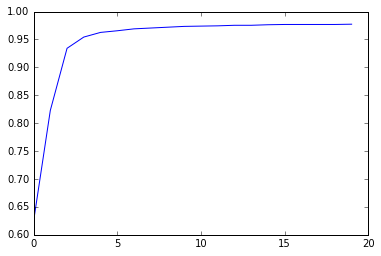

In [60]:
epoches = range(len(error))
plt.plot(epoches, error)
plt.show()

In [105]:
import time
start_time = time.time()
net1 = Network([784,2,2])
error1 = net1.SGD(training_data, 50, 10, 0.005, test_data=validation_data)
time1 = time.time() - start_time

start_time = time.time()
net2 = Network([784,5,2])
error2 = net2.SGD(training_data, 50, 10, 0.005, test_data=validation_data)
time2 = time.time() - start_time

start_time = time.time()
net3 = Network([784,10,2])
error3 = net3.SGD(training_data, 50, 10, 0.005, test_data=validation_data)
time3 = time.time() - start_time

start_time = time.time()
net4 = Network([784,20,2])
error4 = net4.SGD(training_data, 50, 10, 0.005, test_data=validation_data)
epoches = range(len(error))
time4 = time.time() - start_time


Epoch 0: 1010 / 2038
Epoch 1: 1010 / 2038
Epoch 2: 1010 / 2038
Epoch 3: 1323 / 2038
Epoch 4: 1366 / 2038
Epoch 5: 1406 / 2038
Epoch 6: 1438 / 2038
Epoch 7: 1476 / 2038
Epoch 8: 1514 / 2038
Epoch 9: 1555 / 2038
Epoch 10: 1590 / 2038
Epoch 11: 1627 / 2038
Epoch 12: 1654 / 2038
Epoch 13: 1690 / 2038
Epoch 14: 1722 / 2038
Epoch 15: 1732 / 2038
Epoch 16: 1745 / 2038
Epoch 17: 1763 / 2038
Epoch 18: 1776 / 2038
Epoch 19: 1794 / 2038
Epoch 20: 1804 / 2038
Epoch 21: 1815 / 2038
Epoch 22: 1827 / 2038
Epoch 23: 1840 / 2038
Epoch 24: 1847 / 2038
Epoch 25: 1853 / 2038
Epoch 26: 1856 / 2038
Epoch 27: 1866 / 2038
Epoch 28: 1868 / 2038
Epoch 29: 1872 / 2038
Epoch 30: 1876 / 2038
Epoch 31: 1880 / 2038
Epoch 32: 1887 / 2038
Epoch 33: 1891 / 2038
Epoch 34: 1896 / 2038
Epoch 35: 1900 / 2038
Epoch 36: 1902 / 2038
Epoch 37: 1904 / 2038
Epoch 38: 1912 / 2038
Epoch 39: 1915 / 2038
Epoch 40: 1916 / 2038
Epoch 41: 1917 / 2038
Epoch 42: 1918 / 2038
Epoch 43: 1922 / 2038
Epoch 44: 1923 / 2038
Epoch 45: 1925 / 203

In [112]:
start_time = time.time()
net5 = Network([784,100,2])
error5 = net5.SGD(training_data, 150, 10, 0.005, test_data=validation_data)
epoches = range(len(error))
time5 = time.time() - start_time

Epoch 0: 1484 / 2038
Epoch 1: 1671 / 2038
Epoch 2: 1750 / 2038
Epoch 3: 1798 / 2038
Epoch 4: 1830 / 2038
Epoch 5: 1847 / 2038
Epoch 6: 1868 / 2038
Epoch 7: 1883 / 2038
Epoch 8: 1893 / 2038
Epoch 9: 1897 / 2038
Epoch 10: 1901 / 2038
Epoch 11: 1905 / 2038
Epoch 12: 1909 / 2038
Epoch 13: 1917 / 2038
Epoch 14: 1922 / 2038
Epoch 15: 1925 / 2038
Epoch 16: 1925 / 2038
Epoch 17: 1928 / 2038
Epoch 18: 1928 / 2038
Epoch 19: 1931 / 2038
Epoch 20: 1933 / 2038
Epoch 21: 1935 / 2038
Epoch 22: 1936 / 2038
Epoch 23: 1936 / 2038
Epoch 24: 1938 / 2038
Epoch 25: 1938 / 2038
Epoch 26: 1938 / 2038
Epoch 27: 1939 / 2038
Epoch 28: 1940 / 2038
Epoch 29: 1940 / 2038
Epoch 30: 1942 / 2038
Epoch 31: 1943 / 2038
Epoch 32: 1943 / 2038
Epoch 33: 1945 / 2038
Epoch 34: 1946 / 2038
Epoch 35: 1946 / 2038
Epoch 36: 1946 / 2038
Epoch 37: 1947 / 2038
Epoch 38: 1948 / 2038
Epoch 39: 1950 / 2038
Epoch 40: 1950 / 2038
Epoch 41: 1950 / 2038
Epoch 42: 1950 / 2038
Epoch 43: 1950 / 2038
Epoch 44: 1950 / 2038
Epoch 45: 1950 / 203

KeyboardInterrupt: 

In [96]:
time5

59.26225304603577

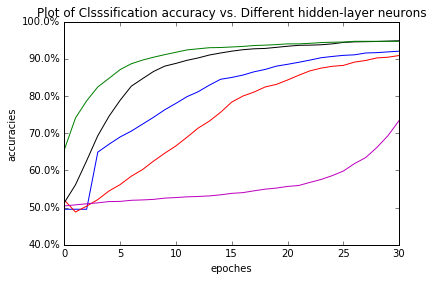

In [113]:
epoches = range(len(error1))
plt.plot(epoches, error1,'b')
plt.plot(epoches, error2,'r')
plt.plot(epoches, error3,'k')
plt.plot(epoches, error4,'g')
plt.plot(epoches, error5,'m')


plt.title('Plot of Clsssification accuracy vs. Different hidden-layer neurons')
plt.xlabel('epoches')# make axis labels
plt.ylabel('accuracies')

plt.xlim(0.0, 30)
plt.ylim(0.4, 1.0)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

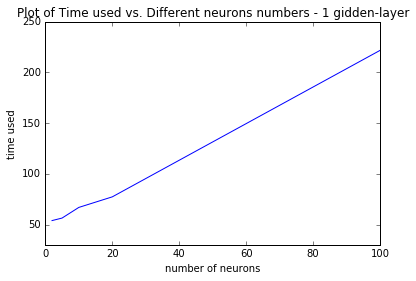

In [114]:
num_neurons = [2,5,10,20,100]
timeused = [time1,time2,time3,time4,time5]

plt.plot(num_neurons, timeused)
plt.title('Plot of Time used vs. Different neurons numbers - 1 gidden-layer')
plt.xlabel('number of neurons')# make axis labels
plt.ylabel('time used')

plt.xlim(0.0, 100)
plt.ylim(30.0, 250.0)

plt.show()


In [108]:
import time
start_time = time.time()
lnet1 = Network([784,5,5,2])
lerror1 = lnet1.SGD(training_data, 50, 10, 0.005, test_data=validation_data)
ltime1 = time.time() - start_time

start_time = time.time()
lnet2 = Network([784,5,5,5,2])
lerror2 = lnet2.SGD(training_data, 50, 10, 0.005, test_data=validation_data)
ltime2 = time.time() - start_time

start_time = time.time()
lnet3 = Network([784,5,5,5,5,2])
lerror3 = lnet3.SGD(training_data, 50, 10, 0.005, test_data=validation_data)
ltime3 = time.time() - start_time

start_time = time.time()
lnet4 = Network([784,5,5,5,5,5,2])
lerror4 = lnet4.SGD(training_data, 50, 10, 0.005, test_data=validation_data)
ltime4 = time.time() - start_time

Epoch 0: 1010 / 2038
Epoch 1: 1010 / 2038
Epoch 2: 1010 / 2038
Epoch 3: 1010 / 2038
Epoch 4: 1010 / 2038
Epoch 5: 1034 / 2038
Epoch 6: 1205 / 2038
Epoch 7: 1254 / 2038
Epoch 8: 1281 / 2038
Epoch 9: 1316 / 2038
Epoch 10: 1347 / 2038
Epoch 11: 1372 / 2038
Epoch 12: 1396 / 2038
Epoch 13: 1426 / 2038
Epoch 14: 1454 / 2038
Epoch 15: 1491 / 2038
Epoch 16: 1515 / 2038
Epoch 17: 1545 / 2038
Epoch 18: 1572 / 2038
Epoch 19: 1593 / 2038
Epoch 20: 1614 / 2038
Epoch 21: 1659 / 2038
Epoch 22: 1680 / 2038
Epoch 23: 1710 / 2038
Epoch 24: 1736 / 2038
Epoch 25: 1760 / 2038
Epoch 26: 1777 / 2038
Epoch 27: 1790 / 2038
Epoch 28: 1802 / 2038
Epoch 29: 1821 / 2038
Epoch 30: 1834 / 2038
Epoch 31: 1846 / 2038
Epoch 32: 1856 / 2038
Epoch 33: 1868 / 2038
Epoch 34: 1876 / 2038
Epoch 35: 1879 / 2038
Epoch 36: 1885 / 2038
Epoch 37: 1888 / 2038
Epoch 38: 1892 / 2038
Epoch 39: 1893 / 2038
Epoch 40: 1895 / 2038
Epoch 41: 1899 / 2038
Epoch 42: 1903 / 2038
Epoch 43: 1909 / 2038
Epoch 44: 1912 / 2038
Epoch 45: 1912 / 203

In [120]:
lerror1[49]

0.943081452404318

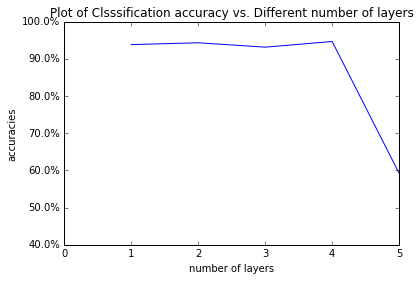

In [122]:
layers = [1,2,3,4,5]
lerror = [error2[49],lerror1[49], lerror2[49], lerror3[49],lerror4[49]]
plt.plot(layers, lerror)


plt.title('Plot of Clsssification accuracy vs. Different number of layers')
plt.xlabel('number of layers')# make axis labels
plt.ylabel('accuracies')

plt.xlim(0.0, 5.0)
plt.ylim(0.4, 1.0)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

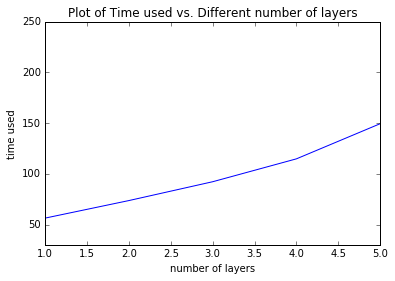

In [124]:
layers = [1,2,3,4,5]
ltimeused = [time2, ltime1, ltime2, ltime3, ltime4]

plt.plot(layers, ltimeused)
plt.title('Plot of Time used vs. Different number of layers')
plt.xlabel('number of layers')# make axis labels
plt.ylabel('time used')

plt.xlim(1.0, 5.0)
plt.ylim(30.0, 250.0)

plt.show()